In [1]:
import os
import re
import gc
import pickle
import xml.sax
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import display
from matplotlib import pyplot as plt

import json
import tqdm
from itertools import chain
from functools import partial
from collections import Counter
from multiprocessing import Pool
from scipy.sparse import csr_matrix
from timeit import default_timer as timer
from multiprocessing.dummy import Pool as Threadpool

In [2]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

In [3]:
set_default()

In [4]:
project = 'enwiki'
dump_date = "20220420"
dataset_home = '/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science/'

partition_dir = f"{dataset_home}/partition_2"

# helper_code

In [5]:
def get_filepath(partition_dir, file_type="redirects"):
    paths = []
    info = []
    
    pattern = re.compile(r'^[0-9a-z-]+-[0-9]+-p[0-9]+p[0-9]+_'+file_type+r'.ndjson$')
    
    for file in sorted(os.listdir(partition_dir)):
        if pattern.match(file):
            paths.append(f'{partition_dir}/{file}')
            info.append(os.stat(f'{partition_dir}/{file}').st_size/1e6)
            
    return paths, info

In [6]:
def show_fileinfo(partition_dir, file_type="redirects", save_file=None, display=True):
    
    paths, info = get_filepath(partition_dir, file_type=file_type)
    
    if display:
        plt.figure(figsize=(15,10))
        plt.bar([os.path.basename(p).split('_')[0]  for p in paths],info, width=0.4)
        plt.setp(plt.gca().get_xticklabels(), rotation=90)

        plt.xlabel("filename")
        plt.ylabel("Size (MB)")
        plt.title(f"Total size of {file_type} files : {np.sum(info):.2f} MB")

    if save_file:
        plt.savefig(save_file)
    
    print(f"Total size of {file_type} files : {np.sum(info):.2f} MB")
    return paths, info

In [7]:
def combine_data(paths):
    threadpool = Threadpool(processes= 10)

    data_list = []
    for data in tqdm.notebook.tqdm(threadpool.map(read_data, paths), total=len(paths)):
        data_list.append(data)
        
    combined_data = {}
    for data in data_list:
        combined_data.update(data)

    m = re.search(r'(.*)/([0-9a-z-]+)-[0-9]+-p[0-9]+p[0-9]+_([a-z-_]+).ndjson$', paths[0])
    save_file = f'{m.group(1)}/{m.group(2)}_{m.group(3)}.ndjson'
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(combined_data))
    
    print(f"Save data into {save_file}")
    return save_file

In [8]:
def read_data(filename):
    with open(filename, 'r') as fin:
        data = json.loads(fin.read())
    return data

In [9]:
def save_data(save_file, data):
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(data))

In [10]:
def multi_proc(func, tasks, num_proc=10):
    
    pool = Pool(processes=num_proc)
    results = []
    for x in tqdm.tqdm( pool.imap(func, tasks), total=len(tasks)):
        results.append(x)
    return results

In [11]:
def print_graph_head(graph, nedges=4, nnodes=5):
    for i, (page_id, (edges, counts)) in enumerate(graph.items()):
        print(f"{i+1}. {page_id} : {edges[:nedges]}")
        if i > nnodes-2:
            break

In [12]:
def get_graph_edge_stats(node_edgecount, ranges=[None, 50, 10],
                         is_hist=True, is_tab=True, is_stat=True, e_type=0):
        
    nec = np.array(list(node_edgecount.values()))
    nec_df_stat = pd.DataFrame([nec.min(axis=0), nec.max(axis=0), nec.mean(axis=0), 
                                nec.std(axis=0), nec.sum(axis=0)], index=['Min', 'Max', 'Mean', 'Std', 'Sum'])
    
    if is_stat:
        df = nec_df_stat.style.set_caption("Edge Stats").format('{:0.2f}')
        display(df)
    
    if is_hist:
        plt.figure(figsize=(15, 4))
        count, rvalue = [], []

        for i, b in enumerate(ranges):
            plt.subplot(1, 3, i+1)
            if b:
                c, r, _ = plt.hist(nec[:, e_type], range=(0, b))
                plt.title(f'range(0, {b})')
            else:
                c, r, _ = plt.hist(nec[:, e_type])
                plt.title('Full range')
            plt.xlabel('edges')
            plt.ylabel('samples')
            count.append(c)
            rvalue.append(r)
            
    if is_tab:
        tables = []
        for c, r, b in zip(count, rvalue, ranges):
            labels = []

            for i in range(len(r)-1):
                l = f'{r[i]:.0f} - {r[i+1]:.0f}'
                labels.append(l)

            if b:
                cap = f'range(0,{b})'
            else:
                cap = 'Full range'

            df = pd.DataFrame(c, index=labels, columns=['count'],dtype='int').T
            tables.append(df)
            display(df.style.set_caption(cap))
    
    return node_edgecount, nec_df_stat

In [13]:
def count_node_edges(filename):
    graph = read_data(filename)
    
    edge_cnt = dict()
    for page_id, (edges, counts) in graph.items():
        edge_cnt[page_id] = (len(edges), np.sum(counts))
    
    num_nodes = len(graph)
    del graph
    gc.collect()
    
    return num_nodes, edge_cnt

# redirects

In [17]:
redirects_file = f'{partition_dir}/enwiki-20220420_redirects.ndjson'
redirects = read_data(redirects_file)

In [ ]:
len(redirects)

In [15]:
for i, (title1, title2) in enumerate(redirects.items()):
    print(f'{i+1}: {title1} - {title2}')
    if i > 4:
        break

1: accessibleComputing - computer accessibility
2: afghanistanHistory - history of Afghanistan
3: afghanistanGeography - geography of Afghanistan
4: afghanistanPeople - demographics of Afghanistan
5: afghanistanCommunications - communications in Afghanistan
6: afghanistanTransportations - transport in Afghanistan


## Making first character of title case insensitive

In [26]:
new_redirects = dict()
for title_1, title_2 in redirects.items():
    if title_1 and title_2:
        title_1 = title_1[0].lower()+title_1[1:]
        title_2 = title_2[0].lower()+title_2[1:]
        new_redirects[title_1] = title_2

In [27]:
for i, (title1, title2) in enumerate(new_redirects.items()):
    print(f'{i+1}: {title1} - {title2}')
    if i > 4:
        break

1: accessibleComputing - computer accessibility
2: afghanistanHistory - history of Afghanistan
3: afghanistanGeography - geography of Afghanistan
4: afghanistanPeople - demographics of Afghanistan
5: afghanistanCommunications - communications in Afghanistan
6: afghanistanTransportations - transport in Afghanistan


In [28]:
save_data(redirects_file, new_redirects)

# id-to-title, title-to-id

In [15]:
id_title_file = f'{partition_dir}/enwiki-20220420_id-to-title.ndjson'

id_to_title = read_data(id_title_file)

In [16]:
len(id_to_title)

6473083

In [18]:
for i, (page_id, title) in enumerate(id_to_title.items()):
    print(f'{i+1}: {page_id} {title}')
    if i > 4:
        break

1: 12 anarchism
2: 25 autism
3: 39 albedo
4: 290 a
5: 303 alabama
6: 305 achilles


## Making first character of title case insensitive

In [36]:
for page_id, title in id_to_title.items():
    id_to_title[page_id] = title[0].lower() + title[1:]

In [37]:
for i, (page_id, title) in enumerate(id_to_title.items()):
    print(f'{i+1}: {page_id} {title}')
    if i > 4:
        break

1: 12 anarchism
2: 25 autism
3: 39 albedo
4: 290 a
5: 303 alabama
6: 305 achilles


In [38]:
save_data(id_title_file, id_to_title)

## title-to-id

In [19]:
title_to_id = {title:page_id for page_id, title in id_to_title.items()}

In [20]:
for i, (title, page_id) in enumerate(title_to_id.items()):
    print(f'{i+1}: {title} {page_id}')
    if i > 4:
        break

1: anarchism 12
2: autism 25
3: albedo 39
4: a 290
5: alabama 303
6: achilles 305


# Graphs

## Remove redirect nodes

### filenames and sizes

Total size of graph files : 4458.83 MB


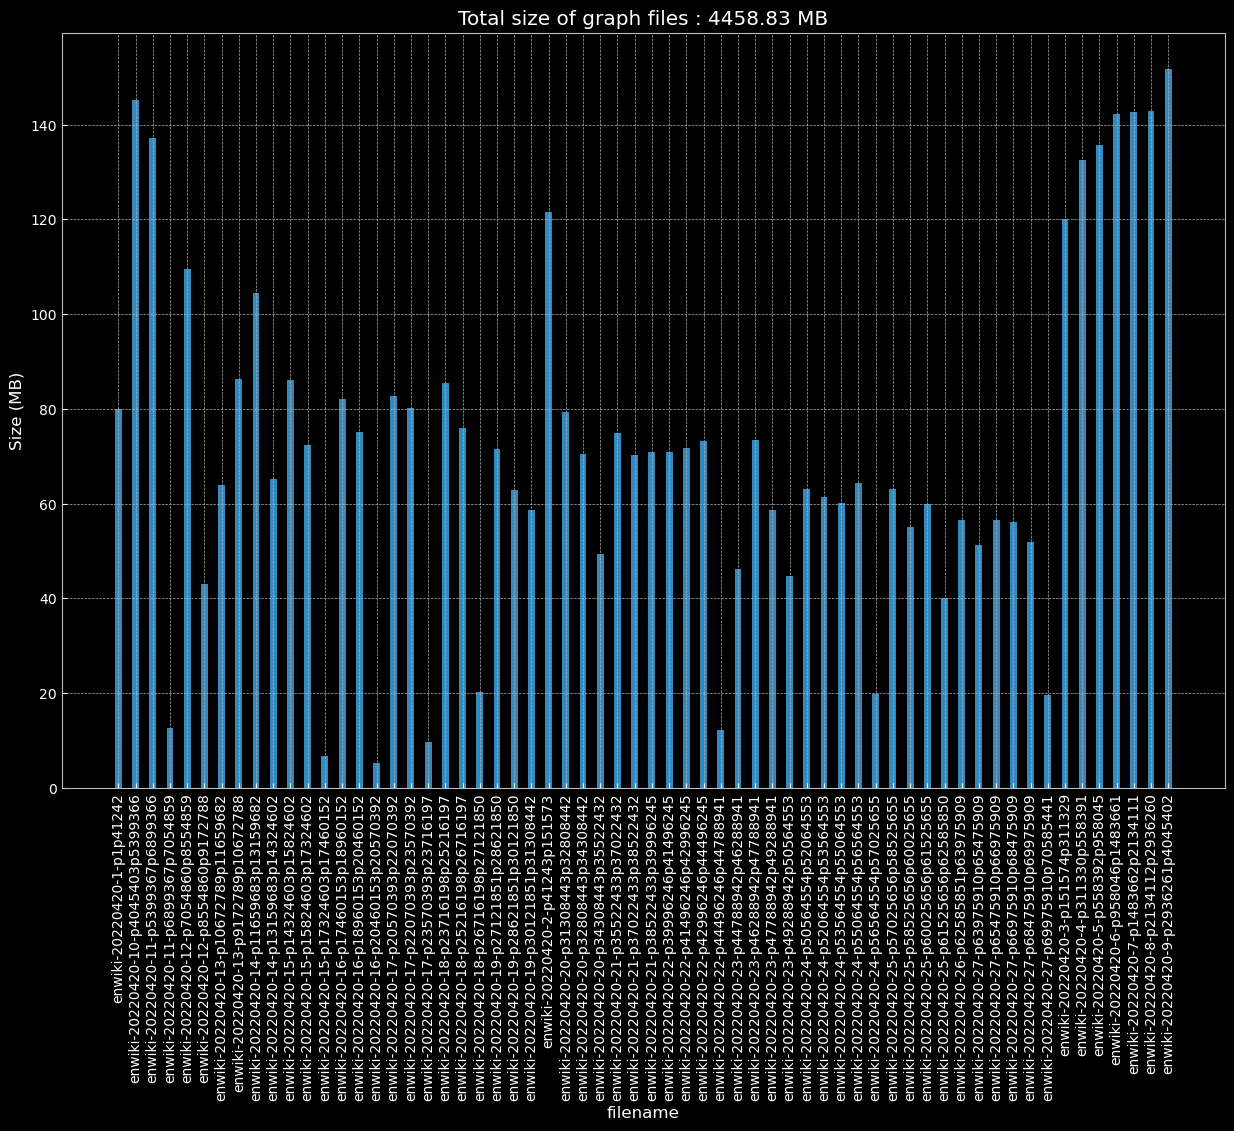

In [43]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph")

### remove

In [44]:
def replace_redirects(path, redirects):

    graph = read_data(path)
    
    for edges, _ in graph.values():
        for i, edge in enumerate(edges):
            if edge:
                edge = edge[0].lower()+edge[1:]
                if edge in redirects:
                    edges[i] = redirects[edge]
           
    m = re.search(r'(.*)/(.*_graph).ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_resolved.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(graph))
        
    return None

In [47]:
start = timer()

pool = Pool(processes=24)
resolve_graph = partial(replace_redirects, redirects=redirects)

result = []
for x in tqdm.notebook.tqdm(pool.imap_unordered(resolve_graph, graph_paths), total=len(graph_paths)):
    result.append(x)

end = timer()
print(f"Processing time {end-start:.3f} seconds.")

  0%|          | 0/62 [00:00<?, ?it/s]

Processing time 467.344 seconds.


## Filenames, sizes

Total size of graph_resolved files : 4494.10 MB


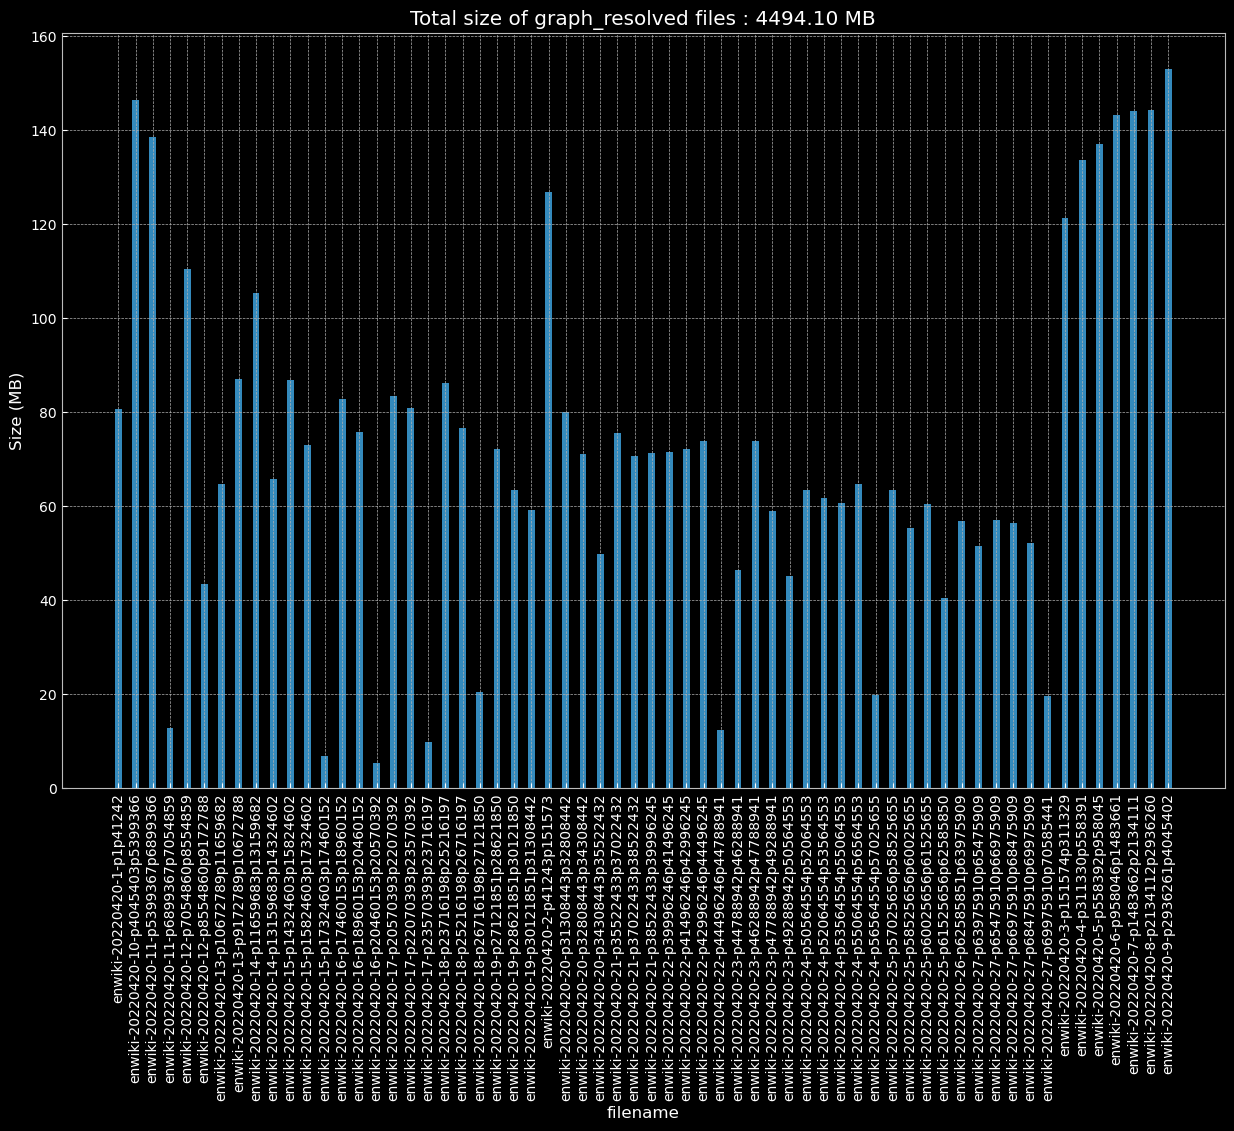

In [48]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph_resolved")

## Checks if all nodes are present in id-to-title

In [50]:
def check_node(filename):
    graph = read_data(filename)
    
    absent_nodes = list()
    for node in graph:
        if node not in id_to_title:
            absent_nodes.append(node)
        
    return absent_nodes

In [51]:
absent_nodes = multi_proc(check_node, graph_paths)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:16<00:00,  3.84it/s]


In [52]:
list(chain(*absent_nodes))

[]

verified that all nodes are present in the map

## Edge statistics

In [133]:
results = multi_proc(edge_counts, graph_paths)

  0%|          | 0/62 [00:00<?, ?it/s]

In [134]:
edge_count = list(chain(*results))

In [135]:
print(f"Minimum number of edges : {np.min(edge_count)}",
      f"Maximum number of edges : {np.max(edge_count)}",
      f"Mean number of edges : {np.mean(edge_count):.3f}",
      f"Std of number of edges : {np.std(edge_count):.3f}", 
      f"Std of number of edges : {np.sum(edge_count)}", sep='\n')

Minimum number of edges : 1
Maximum number of edges : 12059
Mean number of edges : 27.057
Std of number of edges : 62.843
Std of number of edges : 175085364


Text(0.5, 1.0, 'range(0, 50)')

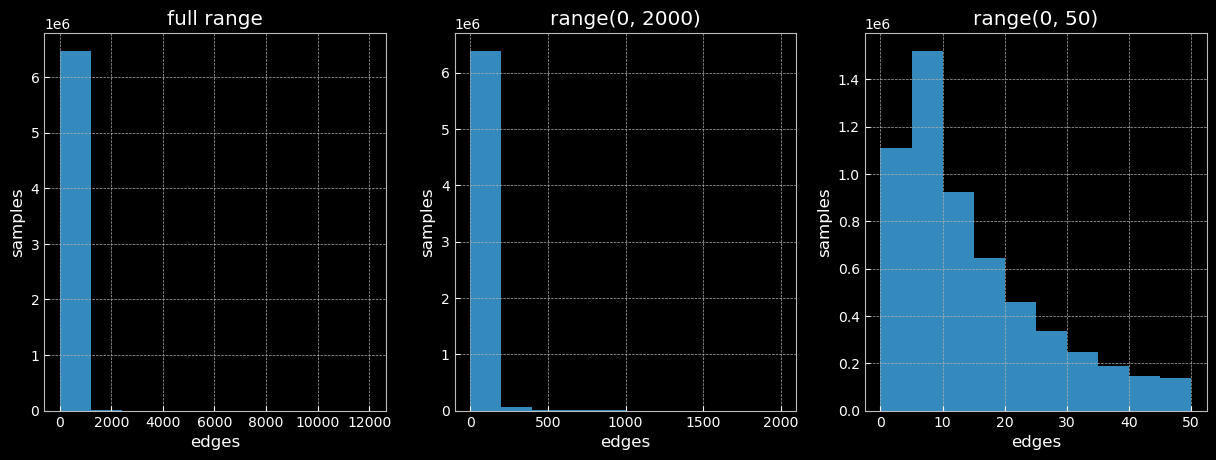

In [151]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
c1, r1, _ = plt.hist(edge_count)
plt.xlabel('edges')
plt.ylabel('samples')
plt.title('full range')

plt.subplot(1, 3, 2)
c2, r2, _ = plt.hist(edge_count, range=(0, 2000))
plt.xlabel('edges')
plt.ylabel('samples')
plt.title('range(0, 2000)')

plt.subplot(1, 3, 3)
c3, r3, _ = plt.hist(edge_count, range=(0, 50))
plt.xlabel('edges')
plt.ylabel('samples')
plt.title('range(0, 50)')

## Remove dead edges

In [53]:
def replace_dead(path, title_to_id):

    graph = read_data(path)
    
    for page_id, (edges, counts) in graph.items():
        active_edges = list()
        active_counts = list()
        
        while edges:
            e = edges.pop()
            c = counts.pop()
            
            if e:
                e = e[0].lower()+e[1:]
                if e in title_to_id:
                    active_edges.append(e)
                    active_counts.append(c)
            
        graph[page_id] = (active_edges, active_counts)
    
    m = re.search(r'(.*)/(.*_graph_resolved).ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_active.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(graph))
    
    del graph
    gc.collect()
    
    return None

In [54]:
remove_dead = partial(replace_dead, title_to_id=title_to_id)
_ = multi_proc(remove_dead, graph_paths)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [05:10<00:00,  5.00s/it]


### statistics

In [16]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph_resolved_active", display=False)

Total size of graph_resolved_active files : 4197.95 MB


In [32]:
results = multi_proc(count_node_edges, graph_paths)

  0%|          | 0/62 [00:00<?, ?it/s]

In [33]:
g_num_nodes = 0
g_node_edgecount = dict()

for nn, nec in results:
    g_num_nodes += nn
    g_node_edgecount.update(nec)

In [34]:
print(f"Number of nodes in the graph : {g_num_nodes}")

Number of nodes in the graph : 6470952


,0,1
Min,0.00,0.00
Max,12047.00,18530.00
Mean,25.39,43.23
Std,57.35,146.25
Sum,164302613.00,279748693.00


,0 - 1205,1205 - 2409,2409 - 3614,3614 - 4819,4819 - 6024,6024 - 7228,7228 - 8433,8433 - 9638,9638 - 10842,10842 - 12047
count,6469354,1337,185,54,15,3,3,0,0,1


,0 - 200,200 - 400,400 - 600,600 - 800,800 - 1000,1000 - 1200,1200 - 1400,1400 - 1600,1600 - 1800,1800 - 2000
count,6393730,58104,10859,3916,1780,946,529,313,221,147


,0 - 10,10 - 20,20 - 30,30 - 40,40 - 50,50 - 60,60 - 70,70 - 80,80 - 90,90 - 100
count,2739536,1571690,772812,418018,251293,163416,111843,80711,59965,50218


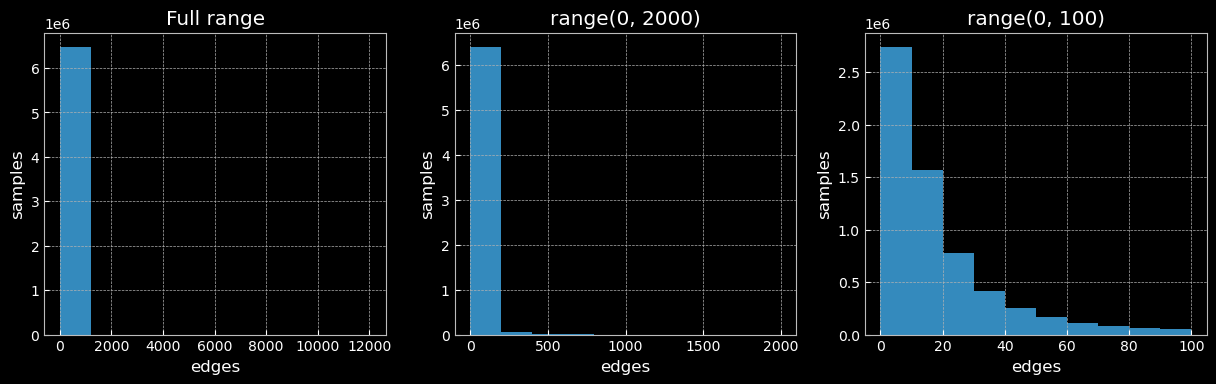

In [37]:
graph_nec, graph_nes = get_graph_edge_stats(g_node_edgecount, ranges=[None, 2000, 100])

## out_graph

In [55]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph_resolved_active", display=False)

Total size of graph_resolved_active files : 4244.05 MB


In [56]:
def create_outgraph(path, title_to_id):
    graph = read_data(path)
    
    out_graph = dict()
    for source_id, (edges, counts) in graph.items():
        for e, c in zip(edges, counts):
            target_id = title_to_id[e]
            edge_count = out_graph.setdefault(source_id, {})
            edge_count[target_id] = edge_count.get(target_id, 0) + c
    
    m = re.search(r'(.*)/(.*)_graph_resolved_active.ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_outgraph_resolved_active.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(out_graph))
    
    del out_graph
    del graph
    gc.collect()
    
    return None

In [57]:
generate_outgraph = partial(create_outgraph, title_to_id=title_to_id)
_ = multi_proc(generate_outgraph, graph_paths)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [06:12<00:00,  6.01s/it]


In [58]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="outgraph_resolved_active", display=False)

Total size of outgraph_resolved_active files : 2303.06 MB


In [59]:
g = read_data(graph_paths[0])
for i, (node, edge_count) in enumerate(g.items()):
    if i > 5:
        break
    print(f'{node} : {list(edge_count.keys())[:5]}')

12 : ['1582235', '166152', '37142', '87066', '33139']
25 : ['1420406', '24884307', '32777', '330316', '24998247']
39 : ['33978', '24059399', '41464', '32236', '66577']
290 : ['2247682', '249007', '5387711', '4949347', '1586113']
303 : ['13388681', '276246', '562516', '32927', '2413292']
305 : ['34398', '1872746', '33433975', '34535', '143331']


### statistics

In [40]:
def count_node_outedges(filename):
    graph = read_data(filename)
    
    edge_cnt = dict()
    for page_id, edge_count in graph.items():
        edge_cnt[page_id] = ( len(edge_count.keys()), np.sum(list(edge_count.values())) )
    
    num_nodes = len(graph)
    del graph
    gc.collect()
    
    return num_nodes, edge_cnt

In [41]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="outgraph_resolved_active", display=False)
results = multi_proc(count_node_outedges, graph_paths)

Total size of outgraph_resolved_active files : 2280.41 MB


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:25<00:00,  2.41it/s]


In [42]:
g_num_nodes = 0
g_node_edgecount = dict()

for nn, nec in results:
    g_num_nodes += nn
    g_node_edgecount.update(nec)
    
print(f"Number of nodes in the graph : {g_num_nodes}")

Number of nodes in the graph : 6469210


,0,1
Min,1.00,1.00
Max,11950.00,18530.00
Mean,24.76,43.24
Std,55.54,146.27
Sum,160185775.00,279748693.00


,1 - 1196,1196 - 2391,2391 - 3586,3586 - 4781,4781 - 5976,5976 - 7170,7170 - 8365,8365 - 9560,9560 - 10755,10755 - 11950
count,6467704,1256,176,53,14,3,3,0,0,1


,0 - 200,200 - 400,400 - 600,600 - 800,800 - 1000,1000 - 1200,1200 - 1400,1400 - 1600,1600 - 1800,1800 - 2000
count,6396910,54621,10093,3643,1595,856,482,291,207,130


,0 - 10,10 - 20,20 - 30,30 - 40,40 - 50,50 - 60,60 - 70,70 - 80,80 - 90,90 - 100
count,2762753,1585332,769007,412297,247020,159864,109002,78270,58017,48811


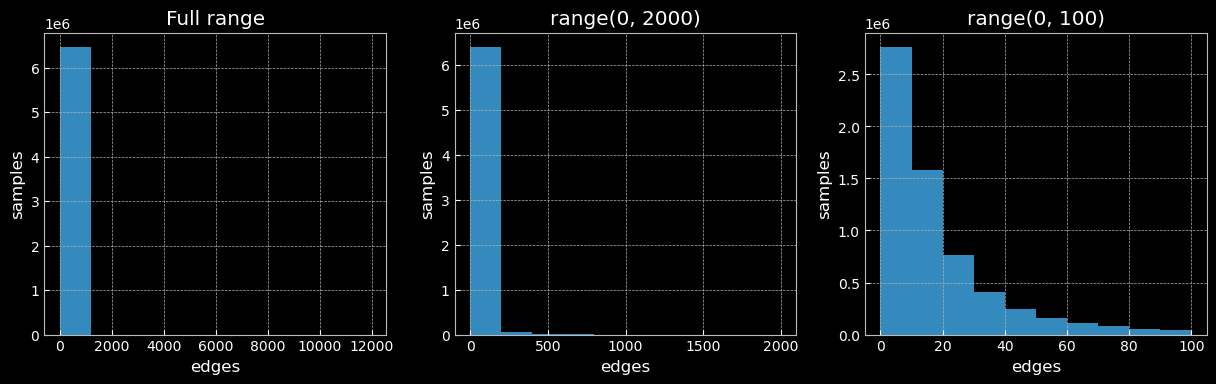

In [43]:
graph_nec, graph_nes = get_graph_edge_stats(g_node_edgecount, ranges=[None, 2000, 100])

## in_graph

In [16]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="graph_resolved_active", display=False)

Total size of graph_resolved_active files : 4197.95 MB


In [19]:
def create_ingraph(path, title_to_id):
    graph = read_data(path)
    
    in_graph = dict()
    for p_id, (es, cs) in graph.items():
        for e, c in zip(es, cs):
            page_id = title_to_id[e]
            edge_count = in_graph.setdefault(page_id, {})
            edge_count[p_id] = edge_count.get(p_id, 0) + c
    
    m = re.search(r'(.*)/(.*)_graph_resolved_active.ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_ingraph_resolved_active.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(in_graph))
    
    del in_graph
    del graph
    gc.collect()
    
    return None

In [22]:
generate_ingraph = partial(create_ingraph, title_to_id=title_to_id)
_ = multi_proc(generate_ingraph, graph_paths)

  0%|          | 0/62 [00:07<?, ?it/s]

In [16]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="ingraph_resolved_active", display=False)

Total size of ingraph_resolved_active files : 3018.33 MB


### Combine in_graph

In [22]:
def combine_ingraph(paths):
    threadpool = Threadpool(processes= 10)
    
    in_graph = {}
    for graph in tqdm.notebook.tqdm(threadpool.map(read_data, paths), total=len(paths)):
        for page_id, ec in graph.items():
            edge_count = in_graph.setdefault(page_id, Counter())
            edge_count.update(ec)
    return in_graph

In [25]:
in_graph = combine_ingraph(graph_paths)

  0%|          | 0/62 [00:00<?, ?it/s]

In [28]:
save_file = f'{partition_dir}/enwiki-20220420_ingraph_resolved_active.ndjson'
save_data(save_file, in_graph)

### Statistics

In [19]:
save_file = f'{partition_dir}/enwiki-20220420_ingraph_resolved_active.ndjson'
in_graph = read_data(save_file)

In [37]:
print(f"Size of the file : {os.stat(save_file).st_size/1e6:.3f} MB")

Size of the file : 2392.270 MB


In [20]:
for i, (page_id, edge_count) in enumerate(in_graph.items()):
    print(f'{page_id} : {list(edge_count.keys())[:4]}')
    if i > 4:
        break

1582235 : ['12', '9567', '14936', '15181']
40949353 : ['12', '5574', '7843', '7959']
40678598 : ['12', '15181', '17865', '18048']
1456771 : ['12', '738', '5588', '7485']
28831284 : ['12', '3986', '4721', '4822']
43134145 : ['12', '1193', '7175', '12720']


In [29]:
ig_node_edgecount = dict()
for i, (page_id, edge_count) in enumerate(in_graph.items()):
    ig_node_edgecount[page_id] = (len(edge_count), np.sum(list(edge_count.values())))

In [30]:
print(f"Number of nodes : {len(in_graph)}")

Number of nodes : 5803503


,0,1
Min,1.00,1.00
Max,234153.00,442010.00
Mean,27.60,48.20
Std,338.01,562.75
Sum,160185775.00,279748693.00


,1 - 23416,23416 - 46831,46831 - 70247,70247 - 93662,93662 - 117077,117077 - 140492,140492 - 163907,163907 - 187323,187323 - 210738,210738 - 234153
count,5803345,121,17,13,3,1,0,1,1,1


,0 - 20,20 - 40,40 - 60,60 - 80,80 - 100,100 - 120,120 - 140,140 - 160,160 - 180,180 - 200
count,4647322,572860,200761,101013,59747,40712,28377,20941,16431,13731


,0 - 10,10 - 20,20 - 30,30 - 40,40 - 50,50 - 60,60 - 70,70 - 80,80 - 90,90 - 100
count,3709941,937381,375226,197634,120076,80685,57763,43250,33137,28976


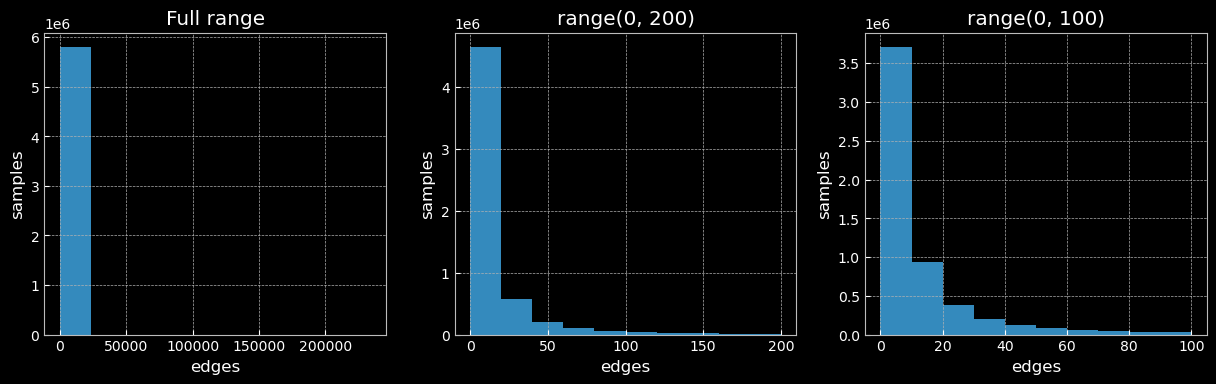

In [33]:
ingraph_nec, ingraph_nes = get_graph_edge_stats(ig_node_edgecount, ranges=[None, 200, 100])

# See also

## filesize

Total size of seealso files : 113.06 MB


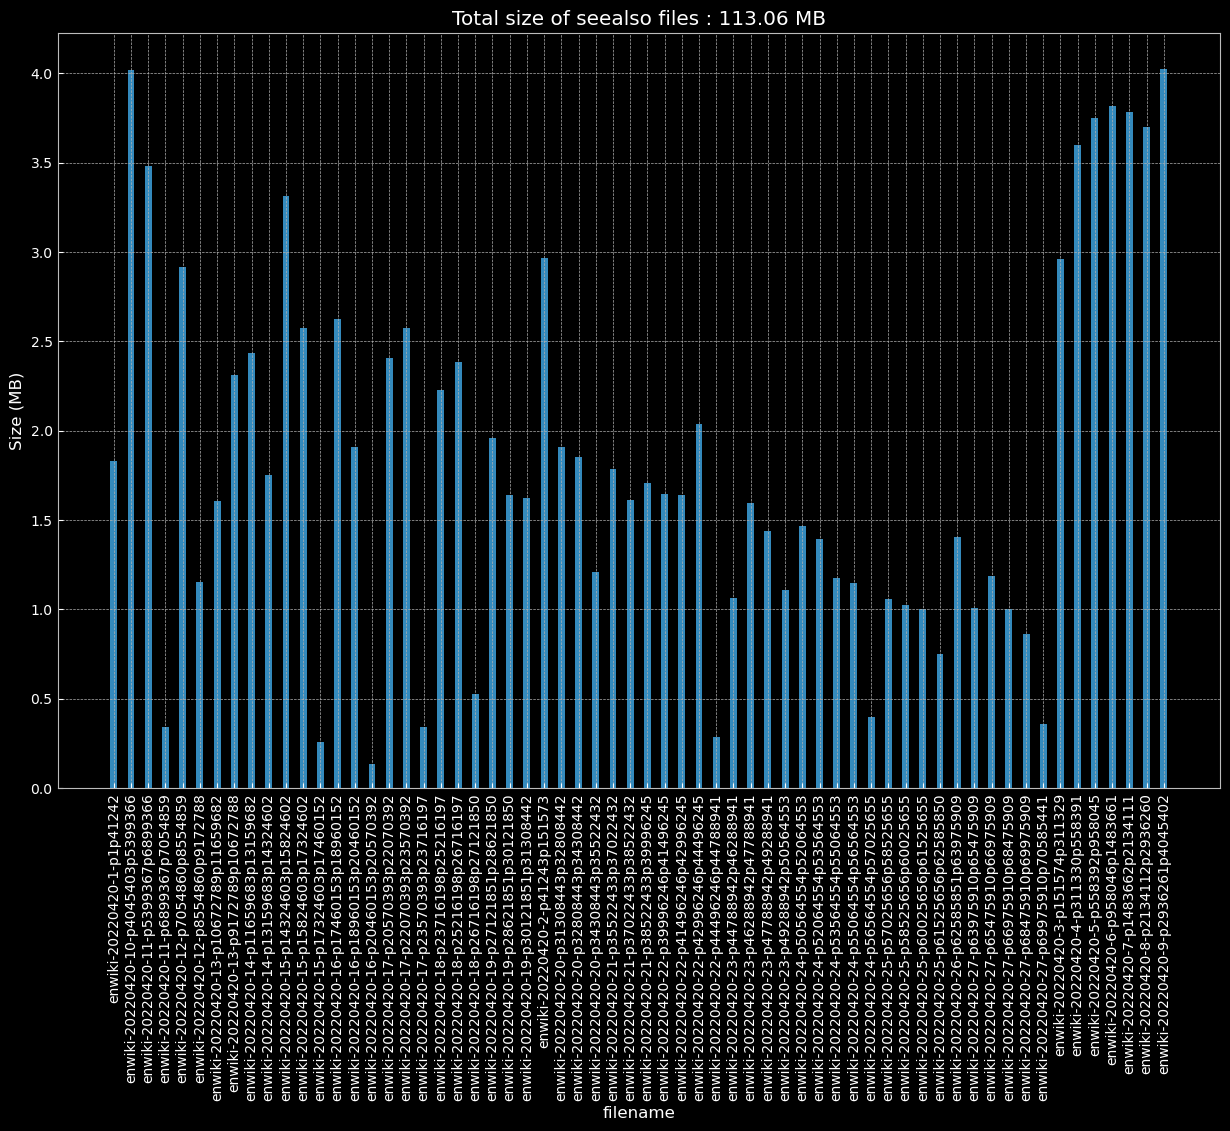

In [61]:
seealso_paths, seealso_info = show_fileinfo(partition_dir, file_type="seealso")

## Combine seealso

In [46]:
#seealso_file = combine_data(seealso_paths)

  0%|          | 0/62 [00:00<?, ?it/s]

Save data into /home/scai/phd/aiz218323/scratch/XML/wikipedia-data-science//partition/enwiki-20220420_seealso.ndjson


In [63]:
seealso_file = f'{partition_dir}/enwiki-20220420_seealso.ndjson'
seealso = read_data(seealso_file)

In [64]:
print_graph_head(seealso)

1. 39 : ['cool roof', 'daisyworld', 'emissivity', 'exitance']
2. 303 : ['index of Alabama-related articles', 'outline of Alabama']
3. 307 : ['film', 'grace Bedell', 'lincoln (film)', 'linconia']
4. 316 : ['bAFTA Award for Best Production Design', "critics' Choice Movie Award for Best Production Design"]
5. 324 : ['list of Academy Award records', 'list of actors with Academy Award nominations', 'list of film awards', 'list of superlative Academy Award winners and nominees']


### statistics

In [57]:
print(f"Number of nodes : {len(seealso)}")

Number of nodes : 1119539


,0,1
Min,1.00,1.00
Max,462.00,463.00
Mean,2.53,2.53
Std,2.88,2.89
Sum,2830248.00,2833997.00


,1 - 47,47 - 93,93 - 139,139 - 185,185 - 232,232 - 278,278 - 324,324 - 370,370 - 416,416 - 462
count,1119371,145,18,2,2,0,0,0,0,1


,0 - 5,5 - 10,10 - 15,15 - 20,20 - 25,25 - 30,30 - 35,35 - 40,40 - 45,45 - 50
count,977036,113936,19190,5424,1980,927,369,238,102,205


,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10
count,0,529544,245880,127710,73902,45337,28577,18631,12708,14867


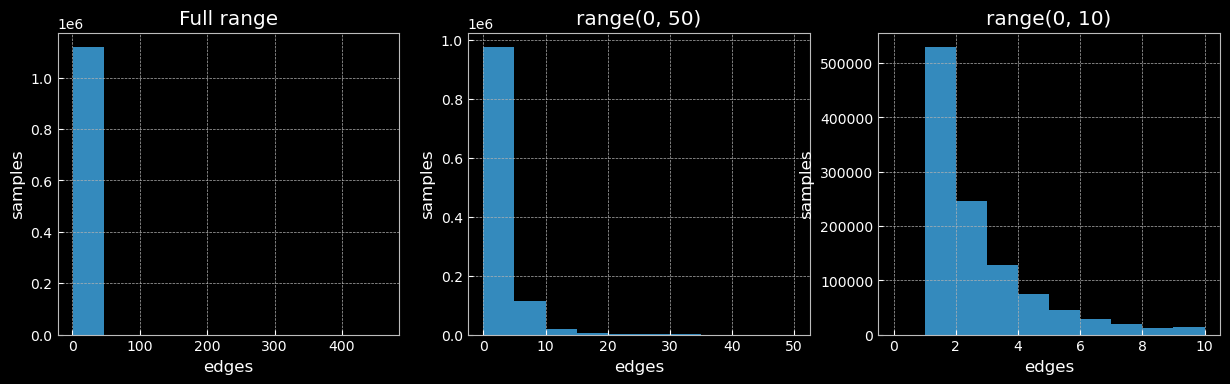

In [117]:
sa_node_edgecount = {}
for page_id, (edges, counts) in seealso.items():
    sa_node_edgecount[page_id] = (len(edges), np.sum(counts))
        
seealso_nec, seealso_nes = get_graph_edge_stats(sa_node_edgecount)

## seealso out_graph

In [65]:
def replace_seealso_redirects(path, redirects):

    graph = read_data(path)
    
    for edges, _ in graph.values():
        for i, edge in enumerate(edges):
            if edge:
                edge = edge[0].lower()+edge[1:]
                if edge in redirects:
                    edges[i] = redirects[edge]
           
    m = re.search(r'(.*)/(.*_seealso).ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_resolved.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(graph))
        
    return save_file

In [66]:
def replace_seealso_dead(path, title_to_id):

    graph = read_data(path)
    
    for page_id, (edges, counts) in graph.items():
        active_edges = list()
        active_counts = list()
        
        while edges:
            e = edges.pop()
            c = counts.pop()
            
            if e:
                e = e[0].lower()+e[1:]
                if e in title_to_id:
                    active_edges.append(e)
                    active_counts.append(c)
            
        graph[page_id] = (active_edges, active_counts)
    
    m = re.search(r'(.*)/(.*_seealso_resolved).ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_active.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(graph))
    
    del graph
    gc.collect()
    
    return save_file

In [67]:
def create_outseealso(path, title_to_id):
    graph = read_data(path)
    
    out_graph = dict()
    for source_id, (edges, counts) in graph.items():
        for e, c in zip(edges, counts):
            target_id = title_to_id[e]
            edge_count = out_graph.setdefault(source_id, {})
            edge_count[target_id] = edge_count.get(target_id, 0) + c
    
    m = re.search(r'(.*)/(.*)_seealso_resolved_active.ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_outseealso_resolved_active.ndjson"

    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(out_graph))

    del out_graph
    del graph
    gc.collect()

    return save_file

In [68]:
seealso_file

'/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science//partition_2/enwiki-20220420_seealso.ndjson'

In [69]:
seealso_file = replace_seealso_redirects(seealso_file, redirects)

In [70]:
seealso_file = replace_seealso_dead(seealso_file, title_to_id)

In [71]:
seealso_file = create_outseealso(seealso_file, title_to_id)

In [72]:
seealso_file

'/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science//partition_2/enwiki-20220420_outseealso_resolved_active.ndjson'

In [21]:
seealso_file = f'{dataset_home}/partition_2/enwiki-20220420_outseealso_resolved_active.ndjson'; seealso_file

'/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science//partition_2/enwiki-20220420_outseealso_resolved_active.ndjson'

#### statistics

In [101]:
seealso = read_data(seealso_file)

In [102]:
print(f"Number of nodes : {len(seealso)}")

Number of nodes : 1105233


,0,1
Min,1.00,1.00
Max,460.00,462.00
Mean,2.49,2.51
Std,2.80,2.84
Sum,2751689.00,2769137.00


,1 - 47,47 - 93,93 - 139,139 - 185,185 - 230,230 - 276,276 - 322,322 - 368,368 - 414,414 - 460
count,1105085,126,18,2,1,0,0,0,0,1


,0 - 5,5 - 10,10 - 15,15 - 20,20 - 25,25 - 30,30 - 35,35 - 40,40 - 45,45 - 50
count,969026,109519,18016,5080,1845,788,373,181,100,188


,0 - 1,1 - 2,2 - 3,3 - 4,4 - 5,5 - 6,6 - 7,7 - 8,8 - 9,9 - 10
count,0,528167,243133,125381,72345,43744,27597,17911,12037,14124


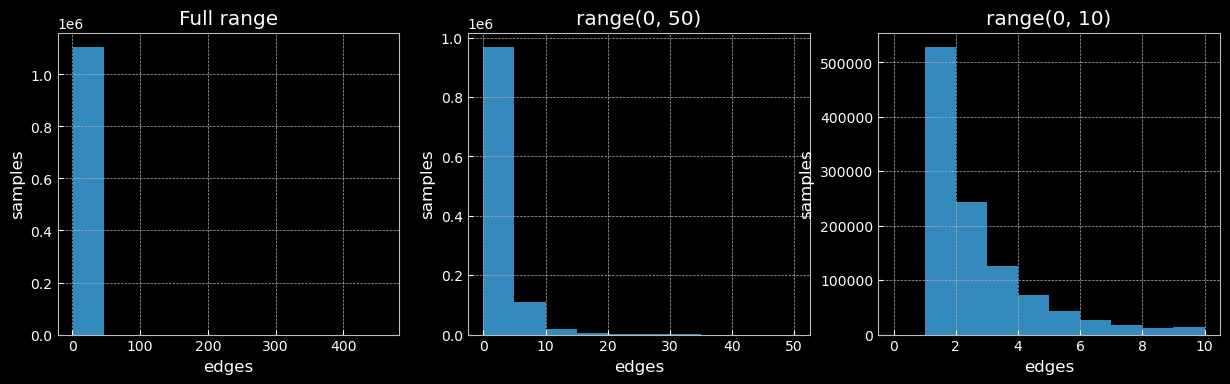

In [104]:
sa_node_edgecount = {}
for page_id, edge_count in seealso.items():
    edges, counts = list(edge_count.keys()), list(edge_count.values())
    sa_node_edgecount[page_id] = (len(edges), np.sum(counts))
        
seealso_nec, seealso_nes = get_graph_edge_stats(sa_node_edgecount)

#### split

In [39]:
def create_seealso_matrix(seealso):
    
    indptr = [0]
    indices = []
    data = []

    doc_to_rowindex = {}

    wikilinks = {}
    for i, (doc, edge_count) in enumerate(seealso.items()):
        doc_to_rowindex[doc] = i

        for link, cnt in edge_count.items():
            index = wikilinks.setdefault(link, len(wikilinks))
            indices.append(index)
            data.append(cnt)
        indptr.append(len(indices))

    seealso_mat = csr_matrix((data, indices, indptr), dtype=int)
    
    return seealso_mat, wikilinks, doc_to_rowindex

In [42]:
seealso = read_data(seealso_file)
seealso_mat, wikilinks, doc_to_rowindex = create_seealso_matrix(seealso)

In [44]:
num_docs, num_labels = seealso_mat.shape
print(f'Number of datapoints\t\t: {num_docs}')
print(f'Number of labels\t\t: {num_labels}')

num_train = int(num_docs*0.7)
num_test = num_docs - num_train
print(f'Number of training points\t: {num_train}')
print(f'Number of testing points\t: {num_test}')

Number of datapoints		: 1105233
Number of labels		: 893680
Number of training points	: 773663
Number of testing points	: 331570


__label count__

In [123]:
label_cnt = np.array(seealso_mat.sum(axis=0)).reshape(-1)

In [124]:
pruned_seealso_mat = seealso_mat[:, label_cnt>1]
rowidx = np.where( np.array(pruned_seealso_mat.sum(axis=1)).reshape(-1) > 0 )[0]

pruned_seealso_mat = pruned_seealso_mat[rowidx, :]

In [125]:
pruned_seealso_mat

<966053x391014 sparse matrix of type '<class 'numpy.int64'>'
	with 2249023 stored elements in Compressed Sparse Row format>

## Train-test split

In [14]:
def prune_map(mapping, idxs):
    rev_mapping = {value:key for key, value in mapping.items()}
    pruned_mapping = {}
    for i, idx in enumerate(idxs):
        pruned_mapping[rev_mapping[idx]] = i
    return pruned_mapping

def split_count(num_samples, perc=0.7):
    num_train = int( np.ceil(num_samples*perc) )
    if num_train == num_samples and num_samples > 1:
        num_train -= 1
    return num_train

In [15]:
class WikipediaSplit:
    
    def __init__(self, graph=None):
        self.graph = None
        self.labels = None
        self.doc_to_rowindex = None
        
        if graph:
            _ = self.to_matrix(graph)
        
        self.train, self.test = None, None
        self.trn_tst_labels = None
        self.train_doc_to_rowindex, self.test_doc_to_rowindex = None, None
        
    def to_matrix(self, graph):
        indptr = [0]
        indices = []
        data = []

        self.doc_to_rowindex = {}

        self.labels = {}
        for i, (doc, edge_count) in enumerate(graph.items()):
            self.doc_to_rowindex[doc] = i

            for link, cnt in edge_count.items():
                index = self.labels.setdefault(link, len(self.labels))
                indices.append(index)
                data.append(cnt)
            indptr.append(len(indices))

        self.graph = csr_matrix((data, indices, indptr), dtype=int)
        return self.graph, self.labels, self.doc_to_rowindex
    
    def clean_matrix(self, clean_type=0):
        if clean_type == 0:
            self.graph, self.labels, self.doc_to_rowindex = self.remove_single_labels(self.graph,
                                                                                      self.labels,
                                                                                      self.doc_to_rowindex)
        elif clean_type == 1:
            pruned_rows = self.get_pruned_row(self.graph)
            self.graph, self.doc_to_rowindex = self.prune_graph_rows(self.graph,
                                                                     self.doc_to_rowindex,
                                                                     pruned_rows)
        else:
            pruned_cols = self.get_pruned_cols(self.graph)
            self.graph, self.labels = self.prune_graph_cols(self.graph,
                                                           self.labels,
                                                           pruned_cols)
    
    """
    def get_split_idx(self):
        train_rowidx = []
        test_rowidx = []
        
        num_rows, num_cols = self.graph.shape
        row_available_flag = np.ones(num_rows, dtype=bool)
        
        label_cnt = np.array(self.graph.sum(axis=0)).reshape(-1)
        uni_label_cnt = np.unique(label_cnt)
        
        for lcnt in uni_label_cnt:
            if lcnt > upper_threshold:
                break
                
            label_pos = np.where(label_cnt == lcnt)[0]
            row_numlabels = np.array(self.graph[:, label_pos].sum(axis=1)).reshape(-1)
            
            row_idx = np.where(row_numlabels > 0)[0]
            row_available_flag[row_idx] = False
            num_train = split_count(row_idx.shape[0], perc=0.7)
            row_idx = list(np.random.permutation(row_idx))

            train_rowidx.extend(row_idx[:num_train])
            test_rowidx.extend(row_idx[num_train:])
        
        row_idx = np.where(row_available_flag == True)[0]
        num_train = split_count(row_idx.shape[0], perc=0.7)
        row_idx = list(np.random.permutation(row_idx))
        train_rowidx.extend(row_idx[:num_train])
        test_rowidx.extend(row_idx[num_train:])
        
        return train_rowidx, test_rowidx
        """
    
    def get_split_idx(self, upper_threshold=10, perc=0.7):
        train_rowidx = []
        test_rowidx = []
        
        row_idxs, col_idxs = self.graph.nonzero()
        sort_idx = np.argsort(col_idxs)
        row_idxs = row_idxs[sort_idx]
        col_idxs = col_idxs[sort_idx]
        
        num_rows = self.graph.shape[0]
        row_inserted_flag = np.zeros(num_rows, dtype=bool)
        
        label_cnt = np.array(self.graph.sum(axis=0)).reshape(-1)
        uni_label_cnt = np.unique(label_cnt)
        
        cnt = 0
        for lcnt in uni_label_cnt:
            if cnt == num_rows or lcnt >= upper_threshold:
                break
                
            pos_ptr, col_ptr = 0, 0
            pos_idxs = np.where(label_cnt == lcnt)[0]
            pos_idxs.sort()

            while col_ptr < len(col_idxs) and pos_ptr < len(pos_idxs) and cnt < num_rows:
                if pos_idxs[pos_ptr] != col_idxs[col_ptr]:
                    col_ptr += 1
                else:
                    sample_row_idxs = []
                    while col_ptr < len(col_idxs) and pos_ptr < len(pos_idxs) and cnt < num_rows and pos_idxs[pos_ptr] == col_idxs[col_ptr]:
                        rn = row_idxs[col_ptr]
                        if not row_inserted_flag[rn]:
                            sample_row_idxs.append(rn)
                            row_inserted_flag[rn] = True
                            cnt += 1
                        col_ptr += 1
                    pos_ptr += 1

                    num_train = split_count(len(sample_row_idxs), perc=0.7)
                    sample_row_idxs = list(np.random.permutation(sample_row_idxs))
                    train_rowidx.extend(sample_row_idxs[:num_train])
                    test_rowidx.extend(sample_row_idxs[num_train:])
                    
        sample_row_idxs = np.where(row_inserted_flag == False)[0]
        num_train = split_count(num_rows, perc=0.7)
        num_train -= len(train_rowidx)
        
        sample_row_idxs = list(np.random.permutation(sample_row_idxs))
        train_rowidx.extend(sample_row_idxs[:num_train])
        test_rowidx.extend(sample_row_idxs[num_train:])
        
        return train_rowidx, test_rowidx
    
    def get_split_bylabel(self, upper_threshold=10, perc=0.7):
        """
        pruning the rows
        """
        train_idx, test_idx = self.get_split_idx(upper_threshold, perc)
        
        self.train = self.graph[train_idx, :]
        self.test = self.graph[test_idx, :]
        self.trn_tst_labels = self.labels
        
        rowindex_to_doc = {row_idx:doc for doc, row_idx in self.doc_to_rowindex.items()}
        
        self.train_doc_to_rowindex = {rowindex_to_doc[idx]:i for i, idx in enumerate(train_idx)}
        self.test_doc_to_rowindex = {rowindex_to_doc[idx]:i for i, idx in enumerate(test_idx)}
        
        """
        pruning the columns
        """
        pruned_cols = self.get_pruned_cols(self.train)
        self.train = self.train[:, pruned_cols]
        self.test = self.test[:, pruned_cols]
        self.trn_tst_labels = prune_map(self.trn_tst_labels, pruned_cols)
        
    def get_random_split_idx(self, perc=0.7):
        n_docs = self.graph.shape[0]
        n_trn = int(perc * n_docs)
        rand_idx = np.random.permutation(n_docs)
        return rand_idx[:n_trn], rand_idx[n_trn:]
    
    def get_pruned_cols(self, graph, count=0):
        label_cnt = np.array(graph.sum(axis=0)).reshape(-1)
        pruned_cols = np.where(label_cnt > count)[0]
        return pruned_cols
    
    def get_pruned_row(self, graph, count=0):
        pruned_rows = np.where( np.array(graph.sum(axis=1)).reshape(-1) > count )[0]
        return pruned_rows
    
    def prune_graph_cols(self, graph, labels, pruned_cols):
        graph = graph[:, pruned_cols]
        labels = prune_map(labels, pruned_cols)
        return graph, labels
    
    def prune_graph_rows(self, graph, doc_to_rowindex, pruned_rows):
        graph = graph[pruned_rows, :]
        doc_to_rowindex = prune_map(doc_to_rowindex, pruned_rows)
        return graph, doc_to_rowindex
    
    def remove_single_labels(self, graph, labels, doc_to_rowindex):
        pruned_cols = self.get_pruned_cols(graph, count=1)
        graph, labels = self.prune_graph_cols(graph, labels, pruned_cols)
        
        pruned_rows = self.get_pruned_row(graph)
        graph, doc_to_rowindex = self.prune_graph_rows(graph, doc_to_rowindex, pruned_rows)

        return graph, labels, doc_to_rowindex
        
    def get_split_byrandom(self, perc=0.7):
        train_idx, test_idx = self.get_random_split_idx(perc)
        
        self.train = self.graph[train_idx, :]
        self.test = self.graph[test_idx, :]
        rowindex_to_doc = {row_idx:doc for doc, row_idx in self.doc_to_rowindex.items()}
        self.train_doc_to_rowindex = {rowindex_to_doc[idx]:i for i, idx in enumerate(train_idx)}
        self.test_doc_to_rowindex = {rowindex_to_doc[idx]:i for i, idx in enumerate(test_idx)}
        
        train_pruned_cols = self.get_pruned_cols(self.train)
        test_pruned_cols = self.get_pruned_cols(self.test)
        pruned_cols = np.intersect1d(train_pruned_cols, test_pruned_cols)
        
        self.train = self.train[:, pruned_cols]
        self.test = self.test[:, pruned_cols]
        self.trn_tst_labels = prune_map(self.labels, pruned_cols)
        
        pruned_rows = self.get_pruned_row(self.train)
        self.train, self.train_doc_to_rowindex = self.prune_graph_rows(self.train, 
                                                                       self.train_doc_to_rowindex, 
                                                                       pruned_rows)
        pruned_rows = self.get_pruned_row(self.test)
        self.test, self.test_doc_to_rowindex = self.prune_graph_rows(self.test,
                                                                     self.test_doc_to_rowindex,
                                                                     pruned_rows)
        
    def save_data(self, save_dir, tag='seealso'):
        train_file = f'{save_dir}/{tag}_train.pkl'
        with open(train_file, 'wb') as fout:
            train = (self.trn_tst_labels, self.train_doc_to_rowindex, self.train)
            pickle.dump(train, fout)
            
        test_file = f'{save_dir}/{tag}_test.pkl'
        with open(test_file, 'wb') as fout:
            test = (self.trn_tst_labels, self.test_doc_to_rowindex, self.test)
            pickle.dump(test, fout)
            
    def load_data(self, save_dir, tag='seealso'):
        train_file = f'{save_dir}/{tag}_train.pkl'
        with open(train_file, 'rb') as fout:
            train = pickle.load(fout)
            self.trn_tst_labels, self.train_doc_to_rowindex, self.train = train
            
        test_file = f'{save_dir}/{tag}_test.pkl'
        with open(test_file, 'rb') as fout:
            test = pickle.load(fout)
            _, self.test_doc_to_rowindex, self.test = test
            

### label distribution

In [30]:
label_cnt[:20]

array([505945, 162340,  76326,  43466,  27001,  18025,  12564,   9224,
         6762,   5244,   4164,   3381,   2792,   2323,   1973,   1717,
         1440,   1219,   1108,    972])

In [31]:
uni_label_cnt[:20]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

<BarContainer object of 50 artists>

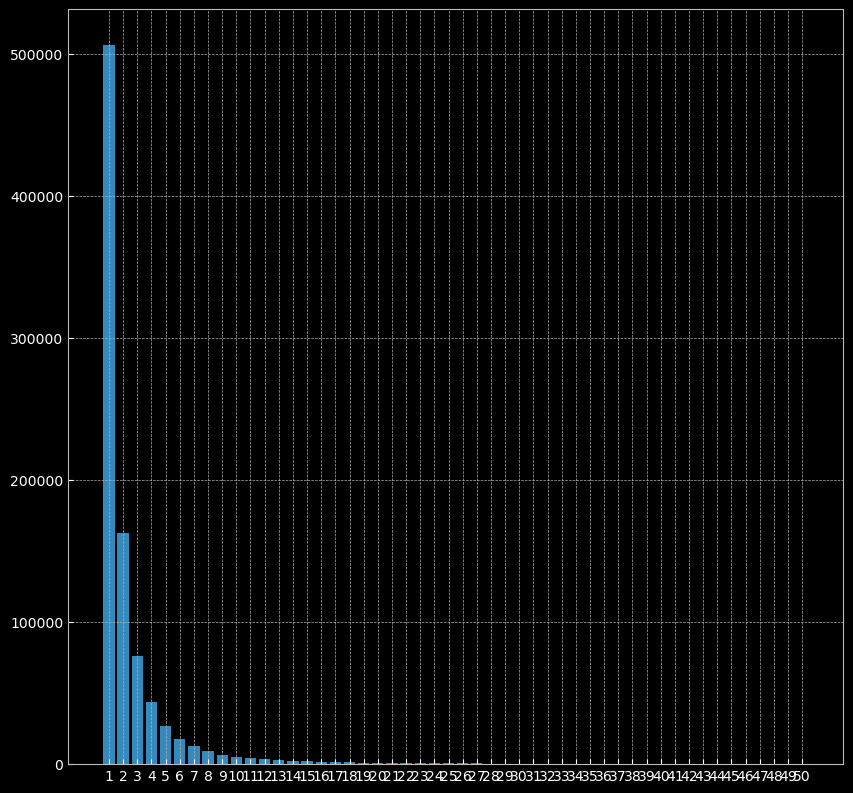

In [27]:
lbl_cnts = np.array(ws.graph.sum(axis=0)).reshape(-1)
uni_label_cnt, label_cnt = np.unique(lbl_cnts, return_counts=True)
plt.bar(list(map(lambda x: str(x),uni_label_cnt))[:50], label_cnt[:50])

### code

In [16]:
seealso_file = f'{partition_dir}/enwiki-20220420_outseealso_resolved_active.ndjson'
seealso = read_data(seealso_file)

In [24]:
len(seealso)

1117416

In [25]:
ws = WikipediaSplit(seealso)

In [26]:
ws.graph

<1117416x901300 sparse matrix of type '<class 'numpy.int64'>'
	with 2799973 stored elements in Compressed Sparse Row format>

In [ ]:
ws.clean_matrix()

In [62]:
ws.graph

<979134x395355 sparse matrix of type '<class 'numpy.int64'>'
	with 2294028 stored elements in Compressed Sparse Row format>

In [50]:
#ws.get_split_byrandom()

In [51]:
ws.train

<609634x251692 sparse matrix of type '<class 'numpy.int64'>'
	with 1273092 stored elements in Compressed Sparse Row format>

In [49]:
num_trn = split_count(ws.graph.shape[0])
num_trn, ws.graph.shape[0] - num_trn

(685394, 293740)

In [63]:
ws.get_split_bylabel(upper_threshold=10)

In [64]:
ws.train, ws.test

(<685394x393921 sparse matrix of type '<class 'numpy.int64'>'
 	with 1570117 stored elements in Compressed Sparse Row format>,
 <293740x393921 sparse matrix of type '<class 'numpy.int64'>'
 	with 720862 stored elements in Compressed Sparse Row format>)

In [65]:
trn_lbl_cnt = np.array(ws.train.sum(axis=0)).reshape(-1)
trn_lbl_cnt_pos = np.where(trn_lbl_cnt == 0)[0]
len(trn_lbl_cnt_pos)

0

In [66]:
tst_lbl_cnt = np.array(ws.test.sum(axis=0)).reshape(-1)
tst_lbl_cnt_pos = np.where( tst_lbl_cnt == 0 )[0]
len(tst_lbl_cnt_pos)

58134

In [67]:
len(np.intersect1d(trn_lbl_cnt_pos, tst_lbl_cnt_pos))

0

In [68]:
save_dir = f'{dataset_home}/partition_2/'
ws.save_data(save_dir, tag='seealso')

#### __test__

In [197]:
g = {'1': {'2':3, '3':1, '4':1}, '4':{'5':1}, '2': {'1':2, '3':1, '4':1}, '3': {'2':1, '4':1}}

In [198]:
g

{'1': {'2': 3, '3': 1, '4': 1},
 '4': {'5': 1},
 '2': {'1': 2, '3': 1, '4': 1},
 '3': {'2': 1, '4': 1}}

### filter out_graph

In [69]:
seealso_file = f'{dataset_home}/partition_2/enwiki-20220420_outseealso_resolved_active.ndjson'
seealso = read_data(seealso_file)

In [70]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="outgraph_resolved_active", display=False)

Total size of outgraph_resolved_active files : 2303.06 MB


In [71]:
def remove_seealso_edges(path, seealso):

    graph = read_data(path)
    
    for sa_node_a, sa_edgecount in seealso.items():
        for sa_node_b in sa_edgecount:
            if sa_node_a in graph and sa_node_b in graph[sa_node_a]:
                del graph[sa_node_a][sa_node_b]
            
            if sa_node_b in graph and sa_node_a in graph[sa_node_b]:
                del graph[sa_node_b][sa_node_a]
    
    m = re.search(r'(.*)/(.*_outgraph_resolved_active).ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_wsar.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(graph))
    
    del graph
    gc.collect()
    
    return None

In [72]:
remove_seealso = partial(remove_seealso_edges, seealso=seealso)
_ = multi_proc(remove_seealso, graph_paths)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [01:54<00:00,  1.85s/it]


In [73]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="outgraph_resolved_active_wsar", display=False)

Total size of outgraph_resolved_active_wsar files : 2281.72 MB


In [74]:
def remove_test_nodes(path, test_nodes):

    graph = read_data(path)
    
    for node in list(graph.keys()):
        if node in test_nodes:
            del graph[node]
        else:
            for edge in list(graph[node].keys()):
                if edge in test_nodes:
                    del graph[node][edge]
    
    m = re.search(r'(.*)/(.*_outgraph_resolved_active_wsar).ndjson$', path)
    save_file = f"{m.group(1)}/{m.group(2)}_wsatestr.ndjson"
    
    with open(save_file, 'wt') as fout:
        fout.write(json.dumps(graph))
    
    del graph
    gc.collect()
    
    return None

In [75]:
test_nodes = set(ws.test_doc_to_rowindex)

In [76]:
remove_test = partial(remove_test_nodes, test_nodes=test_nodes)
_ = multi_proc(remove_test, graph_paths)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:45<00:00,  1.37it/s]


## XC dataset

### load train/test splits

In [32]:
save_dir = f'{dataset_home}/partition_2/'

ws = WikipediaSplit()
ws.load_data(save_dir)

In [33]:
ws.train

<685394x393921 sparse matrix of type '<class 'numpy.int64'>'
	with 1570117 stored elements in Compressed Sparse Row format>

In [34]:
ws.test

<293740x393921 sparse matrix of type '<class 'numpy.int64'>'
	with 720862 stored elements in Compressed Sparse Row format>

In [35]:
len(ws.trn_tst_labels), len(ws.train_doc_to_rowindex), len(ws.test_doc_to_rowindex)

(393921, 685394, 293740)

In [45]:
(np.array(ws.train.sum(axis=1)).reshape(-1).sum()+np.array(ws.test.sum(axis=1)).reshape(-1).sum())/(ws.train.shape[0] + ws.test.shape[0])

2.3600314155161604

### load abstract

In [81]:
abstract_file = f'{partition_dir}/enwiki-20220420-abstracts.ndjson'
abstracts = read_data(abstract_file)

### save files

In [286]:
def modify_abstracts(abstracts):
    page_titles, contents = zip(*abstracts.items())

    for page_title, content in zip(page_titles, contents):
        mod_page_title = page_title[0].lower() + page_title[1:]
        abstracts[mod_page_title] = abstracts[page_title]
        del abstracts[page_title]
        
#modify_abstracts(abstracts)
#save_data(abstract_file, abstracts)

In [83]:
train_map = f'{partition_dir}/train_map.txt'
train_raw = f'{partition_dir}/train_raw_text.txt'

In [84]:
with open(train_map, 'w') as fout:
    for doc_id in sorted(ws.train_doc_to_rowindex, key=lambda x : ws.train_doc_to_rowindex[x]):
        fout.write(f'{doc_id}->{id_to_title[doc_id]}\n')

In [85]:
with open(train_raw, 'w') as fout:
    for doc_id in sorted(ws.train_doc_to_rowindex, key=lambda x : ws.train_doc_to_rowindex[x]):
        if id_to_title[doc_id] in abstracts:
            fout.write(f'{doc_id}->{abstracts[id_to_title[doc_id]]}\n')
        else:
            fout.write(f'{doc_id}->\n')

In [86]:
test_map = f'{partition_dir}/test_map.txt'
test_raw = f'{partition_dir}/test_raw_text.txt'

In [87]:
with open(test_map, 'w') as fout:
    for doc_id in sorted(ws.test_doc_to_rowindex, key=lambda x : ws.test_doc_to_rowindex[x]):
        fout.write(f'{doc_id}->{id_to_title[doc_id]}\n')

In [88]:
with open(test_raw, 'w') as fout:
    for doc_id in sorted(ws.test_doc_to_rowindex, key=lambda x : ws.test_doc_to_rowindex[x]):
        if id_to_title[doc_id] in abstracts:
            fout.write(f'{doc_id}->{abstracts[id_to_title[doc_id]]}\n')
        else:
            fout.write(f'{doc_id}->\n')

In [89]:
label_map = f'{partition_dir}/label_map.txt'

In [90]:
with open(label_map, 'w') as fout:
    for doc_id in sorted(ws.trn_tst_labels, key=lambda x : ws.trn_tst_labels[x]):
        fout.write(f'{doc_id}->{id_to_title[doc_id]}\n')

#### train-test

In [91]:
def save_sparse_file(matrix, save_file):
    matrix.sort_indices()
    rows, cols = matrix.nonzero()
    data = matrix.data
    
    with open(save_file, 'w') as fout:
        fout.write(f'{matrix.shape[0]} {matrix.shape[1]}\n')
    
        row_ctr = -1
        line = ''
        for r, c, d in zip(rows, cols, data):
            if row_ctr == r:
                line = line+f' {c}:{d}'
            elif row_ctr+1 == r:
                if line:
                    fout.write(f'{line}\n')
                line = f'{c}:{d}'
                row_ctr += 1
            else:
                raise Exception("Row is missing.")

In [92]:
train_file = f'{partition_dir}/trn_X_Y.txt'
save_sparse_file(ws.train, train_file)

In [93]:
test_file = f'{partition_dir}/tst_X_Y.txt'
save_sparse_file(ws.test, test_file)

#### Mistake

In [213]:
label_train = f'{partition_dir}/filter_labels_train.txt'

In [222]:
rowindex_to_doc = {val:key for key, val in ws.train_doc_to_rowindex.items()}
colindex_to_lbl = {val:key for key, val in ws.trn_tst_labels.items()}

In [228]:
with open(label_train, 'w') as fout: 
    for r, c in zip(*ws.train.nonzero()):
        fout.write(f'{rowindex_to_doc[r]} {colindex_to_lbl[c]}')

In [229]:
label_test = f'{partition_dir}/filter_labels_test.txt'

In [230]:
rowindex_to_doc = {val:key for key, val in ws.test_doc_to_rowindex.items()}
colindex_to_lbl = {val:key for key, val in ws.trn_tst_labels.items()}

In [231]:
with open(label_test, 'w') as fout: 
    for r, c in zip(*ws.test.nonzero()):
        fout.write(f'{rowindex_to_doc[r]} {colindex_to_lbl[c]}')

In [232]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="outgraph_resolved_active_wsar_wsatestr", 
                                        display=False)

Total size of outgraph_resolved_active_wsar_wsatestr files : 1932.81 MB


In [234]:
len(graph_paths)

62

## Combine graph

In [285]:
graph_paths, graph_info = show_fileinfo(partition_dir, file_type="outgraph_resolved_active_wsar_wsatestr", 
                                        display=False)

Total size of outgraph_resolved_active_wsar_wsatestr files : 1893.07 MB


In [286]:
combined_graph_file = combine_data(graph_paths)

  0%|          | 0/62 [00:00<?, ?it/s]

Save data into /home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science//partition_2/enwiki-20220420_outgraph_resolved_active_wsar_wsatestr.ndjson


In [288]:
combined_graph_file

'/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science//partition_2/enwiki-20220420_outgraph_resolved_active_wsar_wsatestr.ndjson'

In [17]:
combined_graph_file = f'{partition_dir}/enwiki-20220420_outgraph_resolved_active_wsar_wsatestr.ndjson'
combined_graph_file

'/home/cse/phd/anz198717/scratch/suchith_data/wikipedia/wikipedia-data-science//partition_2/enwiki-20220420_outgraph_resolved_active_wsar_wsatestr.ndjson'

In [18]:
graph = read_data(combined_graph_file)

In [19]:
wg = WikipediaSplit(graph)

In [20]:
wg.clean_matrix(clean_type=1)

In [21]:
wg.graph

<6162397x5471498 sparse matrix of type '<class 'numpy.int64'>'
	with 131500666 stored elements in Compressed Sparse Row format>

In [25]:
wg.graph.sum(axis=1).mean()

37.48631725609369

In [ ]:
wg.graph.sum(axis=1).mean()

In [98]:
graph_map = f'{partition_dir}/graph_train_map.txt'
graph_raw = f'{partition_dir}/graph_train_raw_text.txt'

In [99]:
with open(graph_map, 'w') as fout:
    for doc_id in sorted(wg.doc_to_rowindex, key=lambda x : wg.doc_to_rowindex[x]):
        fout.write(f'{doc_id}->{id_to_title[doc_id]}\n')

In [100]:
with open(graph_raw, 'w') as fout:
    for doc_id in sorted(wg.doc_to_rowindex, key=lambda x : wg.doc_to_rowindex[x]):
        if id_to_title[doc_id] in abstracts:
            fout.write(f'{doc_id}->{abstracts[id_to_title[doc_id]]}\n')
        else:
            fout.write(f'{doc_id}->\n')

In [101]:
graph_label_map = f'{partition_dir}/graph_label_map.txt'
graph_label_raw = f'{partition_dir}/graph_label_raw_text.txt'

In [108]:
with open(graph_label_map, 'w') as fout:
    for doc_id in sorted(wg.labels, key=lambda x : wg.labels[x]):
        fout.write(f'{doc_id}->{id_to_title[doc_id]}\n')

In [109]:
with open(graph_label_raw, 'w') as fout:
    for doc_id in sorted(wg.labels, key=lambda x : wg.labels[x]):
        if id_to_title[doc_id] in abstracts:
            fout.write(f'{doc_id}->{abstracts[id_to_title[doc_id]]}\n')
        else:
            fout.write(f'{doc_id}->\n')

In [110]:
graph_file = f'{partition_dir}/graph_trn_X_Y.txt'
save_sparse_file(wg.graph, graph_file)